<h1>Import and Install Dependencies</h1>


In [1]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
from scipy import signal
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<h1>Build Data Loading Function</h1>

In [2]:
#Data loading function
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    return tf.squeeze(wav,axis=-1)

<h1>Create Tensorflow Dataset</h1>

In [3]:
#Paths to positive and negative data
localFolder = os.getcwd()
# For a local use :
#POS = os.path.join(localFolder,'data','positive')
#NEG = os.path.join(localFolder,'data','negative')
# For a drive use :
POS = '/content/drive/MyDrive/ENSC - Travail Mathys/2A/S8/PII/Code/data/positive'
NEG = '/content/drive/MyDrive/ENSC - Travail Mathys/2A/S8/PII/Code/data/negative'

#Tenseflow dataset
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

#Labels and combine
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

<h1>Determine average length of a scream</h1>

In [4]:
#Calculate the average length of a scream/shout
lengths = []
for file in os.listdir(POS):
    tensor_wave = load_wav_16k_mono(os.path.join(POS,file))
    lengths.append(len(tensor_wave))

In [5]:
#Average length of a scream (useful for the preprocess function)
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=132576>

<h1>Build Preprocessing Function to Convert to Spectrogram</h1>

In [4]:
#Preprocessing function
def preprocess (file_path, label):
    #WAV File treatment
    wav = load_wav_16k_mono(file_path)
    #Taking the average length of a scream in the file
    wav = wav[:130000]
    #Completing with zeros if the file is smaller
    zero_padding = tf.zeros([130000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding,wav],0)
    #Fourier transform to get the spectrogram
    spectrogram = tf.signal.stft(wav, frame_length=256, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

<h1>Create Training and Testing Partitions</h1>

In [5]:
#Tensorflow Data Pipeline
data = data.map(preprocess)
data = data.cache()
#Shuffle data to avoid bias
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

#Split into Training and Testing Partitions
train = data.take(18)
test = data.skip(18).take(8)

<h1>Build Deep Learning Model</h1>


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [7]:
#Build Sequential Model, Compile and View Summary
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(4055, 129, 1))) #input_shape depending of the samples size
model.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [8]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 4053, 127, 16)     160       
                                                                 
 conv2d_1 (Conv2D)           (None, 4051, 125, 16)     2320      
                                                                 
 flatten (Flatten)           (None, 8102000)           0         
                                                                 
 dense (Dense)               (None, 128)               1037056128
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,037,058,737
Trainable params: 1,037,058,737
Non-trainable params: 0
_________________________________________________________________


In [10]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
18/18 [==============================] - 33s 90ms/step - loss: 10.5017 - recall: 0.7898 - precision: 0.7020 - val_loss: 0.5834 - val_recall: 0.9867 - val_precision: 0.7629
Epoch 2/4
18/18 [==============================] - 1s 75ms/step - loss: 0.4165 - recall: 0.9382 - precision: 0.9126 - val_loss: 0.1307 - val_recall: 0.9620 - val_precision: 1.0000
Epoch 3/4
18/18 [==============================] - 1s 76ms/step - loss: 0.1207 - recall: 0.9330 - precision: 1.0000 - val_loss: 0.0832 - val_recall: 0.9625 - val_precision: 0.9872
Epoch 4/4
18/18 [==============================] - 1s 76ms/step - loss: 0.0979 - recall: 0.9508 - precision: 0.9943 - val_loss: 0.0590 - val_recall: 0.9571 - val_precision: 1.0000


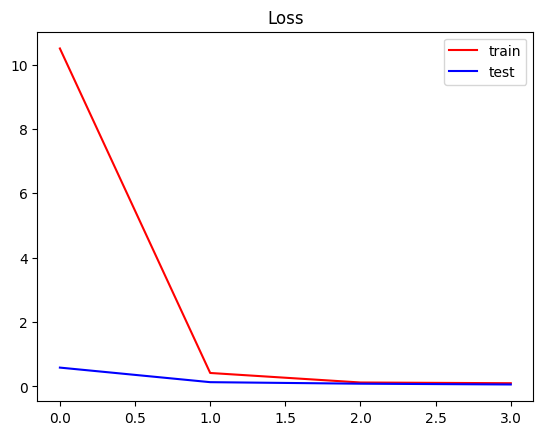

In [11]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r',label="train")
plt.plot(hist.history['val_loss'], 'b',label="test")
plt.legend()
plt.show()

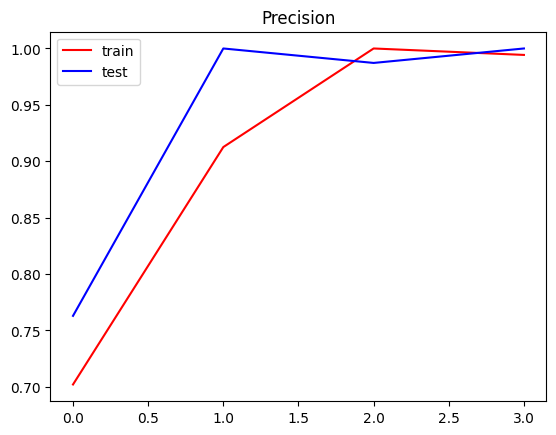

In [12]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r', label="train")
plt.plot(hist.history['val_precision'], 'b', label="test")
plt.legend()
plt.show()

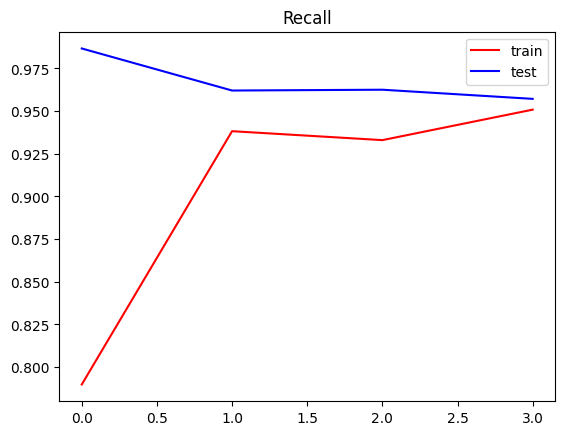

In [13]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r',label="train")
plt.plot(hist.history['val_recall'], 'b',label="test")
plt.legend()
plt.show()

In [14]:
#Save the model
model.save('/content/drive/MyDrive/screamDetection.h5')

<h1>Tests</h1>



In [ ]:
test = '/content/drive/MyDrive/test/0myvoice1.wav'

In [ ]:
test = load_wav_16k_mono(test)

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(test, test, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [ ]:
samples, index = audio_slices.as_numpy_iterator().next()

In [ ]:
len(audio_slices)

2

In [ ]:
#Preprocessing function
def preprocess_samples (sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([130000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding,sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=256, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [ ]:
audio_slices = audio_slices.map(preprocess_samples)
audio_slices = audio_slices.batch(64)

In [ ]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.99 else 0 for prediction in yhat]

1/1 [==============================] - 0s 263ms/step


In [ ]:
yhat

[0, 0]

In [ ]:
#Group consecutive detections
from itertools import groupby

In [ ]:
yhat = [key for key, group in groupby(yhat)]

In [ ]:
tf.math.reduce_sum(yhat)

<tf.Tensor: shape=(), dtype=int32, numpy=1>